In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import torch
import torch.nn as nn

In [2]:
data_ticker = 'SIRI.BK'
data_index = yf.download (data_ticker,start="2014-07-10", end="2024-09-15")

[*********************100%***********************]  1 of 1 completed


In [3]:
data_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2476 entries, 2014-07-10 to 2024-09-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2476 non-null   float64
 1   High       2476 non-null   float64
 2   Low        2476 non-null   float64
 3   Close      2476 non-null   float64
 4   Adj Close  2476 non-null   float64
 5   Volume     2476 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 135.4 KB


In [4]:
data_index.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2.476000e+03
mean,1.535342,1.554448,1.515305,1.533586,1.002704,1.038986e+08
std,0.412205,0.415802,0.407462,0.411570,0.320495,1.466567e+08
min,0.550000,0.560000,0.520000,0.540000,0.384897,0.000000e+00
25%,1.240000,1.260000,1.230000,1.240000,0.808272,3.341022e+07
50%,1.630000,1.650000,1.620000,1.630000,0.923128,6.063130e+07
75%,1.820000,1.840000,1.790000,1.810000,1.172701,1.164243e+08
max,2.480000,2.480000,2.440000,2.440000,1.850796,2.145637e+09


In [5]:
data_index.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-10,2.004999,2.130312,1.987098,2.112410,0.967453,407469748
2014-07-14,2.112410,2.166116,2.076607,2.112410,0.967453,217265144
2014-07-15,2.112410,2.148214,2.058705,2.076607,0.951056,148527866
2014-07-16,2.076607,2.130312,2.058705,2.094508,0.959254,167957437
2014-07-17,2.112410,2.112410,2.076607,2.076607,0.951056,49962949


In [6]:
data_index.reset_index(inplace = True)

In [7]:
data = data_index[['Date', 'Close']]
data

,Date,Close
0,2014-07-10,2.112410
1,2014-07-14,2.112410
2,2014-07-15,2.076607
3,2014-07-16,2.094508
4,2014-07-17,2.076607
...,...,...
2471,2024-09-09,1.780000
2472,2024-09-10,1.830000
2473,2024-09-11,1.810000
2474,2024-09-12,1.840000


In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

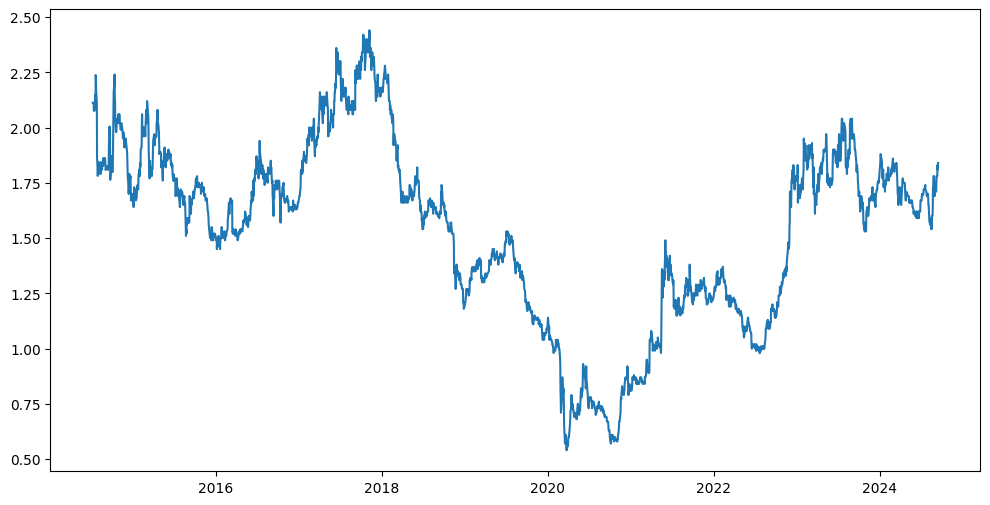

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])


In [10]:
from copy import deepcopy as dc

#Here I create lagged features for an LSTM model 
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-07-22,2.094508,2.148214,2.076607,2.076607,2.094508,2.076607,2.112410,2.112410
2014-07-23,2.237723,2.094508,2.148214,2.076607,2.076607,2.094508,2.076607,2.112410
2014-07-24,2.219821,2.237723,2.094508,2.148214,2.076607,2.076607,2.094508,2.076607
2014-07-25,2.166116,2.219821,2.237723,2.094508,2.148214,2.076607,2.076607,2.094508
2014-07-28,2.112410,2.166116,2.219821,2.237723,2.094508,2.148214,2.076607,2.076607
...,...,...,...,...,...,...,...,...
2024-09-09,1.780000,1.780000,1.740000,1.710000,1.710000,1.710000,1.710000,1.690000
2024-09-10,1.830000,1.780000,1.780000,1.740000,1.710000,1.710000,1.710000,1.710000
2024-09-11,1.810000,1.830000,1.780000,1.780000,1.740000,1.710000,1.710000,1.710000


In [11]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[2.09450793, 2.1482141 , 2.07660699, ..., 2.07660699, 2.11241007,
        2.11241007],
       [2.23772311, 2.09450793, 2.1482141 , ..., 2.09450793, 2.07660699,
        2.11241007],
       [2.21982098, 2.23772311, 2.09450793, ..., 2.07660699, 2.09450793,
        2.07660699],
       ...,
       [1.80999994, 1.83000004, 1.77999997, ..., 1.71000004, 1.71000004,
        1.71000004],
       [1.84000003, 1.80999994, 1.83000004, ..., 1.74000001, 1.71000004,
        1.71000004],
       [1.84000003, 1.84000003, 1.80999994, ..., 1.77999997, 1.74000001,
        1.71000004]])

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[0.63632409, 0.69285689, 0.61748099, ..., 0.61748099, 0.65516844,
        0.65516844],
       [0.7870769 , 0.63632409, 0.69285689, ..., 0.63632409, 0.61748099,
        0.65516844],
       [0.76823255, 0.7870769 , 0.63632409, ..., 0.61748099, 0.63632409,
        0.61748099],
       ...,
       [0.336842  , 0.35789473, 0.30526308, ..., 0.23157894, 0.23157894,
        0.23157894],
       [0.36842104, 0.336842  , 0.35789473, ..., 0.26315786, 0.23157894,
        0.23157894],
       [0.36842104, 0.36842104, 0.336842  , ..., 0.30526308, 0.26315786,
        0.23157894]])

In [13]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2469, 7), (2469,))

In [14]:
X = dc(np.flip(X, axis=1))
X

array([[0.65516844, 0.65516844, 0.61748099, ..., 0.61748099, 0.61748099,
        0.69285689],
       [0.65516844, 0.61748099, 0.63632409, ..., 0.61748099, 0.69285689,
        0.63632409],
       [0.61748099, 0.63632409, 0.61748099, ..., 0.69285689, 0.63632409,
        0.7870769 ],
       ...,
       [0.23157894, 0.23157894, 0.23157894, ..., 0.30526308, 0.30526308,
        0.35789473],
       [0.23157894, 0.23157894, 0.26315786, ..., 0.30526308, 0.35789473,
        0.336842  ],
       [0.23157894, 0.26315786, 0.30526308, ..., 0.35789473, 0.336842  ,
        0.36842104]])

In [15]:
split_index = int(len(X) * 0.95)

split_index

2345

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2345, 7), (124, 7), (2345,), (124,))

In [17]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2345, 7, 1), (124, 7, 1), (2345, 1), (124, 1))

In [18]:
#here i change train and test set to PytorchTensor

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2345, 7, 1]),
 torch.Size([124, 7, 1]),
 torch.Size([2345, 1]),
 torch.Size([124, 1]))

In [19]:
from torch.utils.data import Dataset

#create dataset 
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
train_dataset

In [21]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [23]:
#creating our model
#self will take in input_size the features 1 for each step of the feature if only have 1 feature we input 1
# total of (7) featureswill parse into hidden size's dimension

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
def train_one_epoch():
    model.train()
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [25]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch) #Xbatch predicts Y
            loss = loss_function(output, y_batch) # Y and ground truth
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader) #average loss value 

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [26]:
#training loop 
learning_rate = 0.001
num_epochs = 8
loss_function = nn.MSELoss()

#inserting Adam Algorithm from Pytorch Document
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.234

Val Loss: 0.015
***************************************************

Epoch: 2
Batch 100, Loss: 0.036

Val Loss: 0.007
***************************************************

Epoch: 3
Batch 100, Loss: 0.013

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.009

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.002
***************************************************



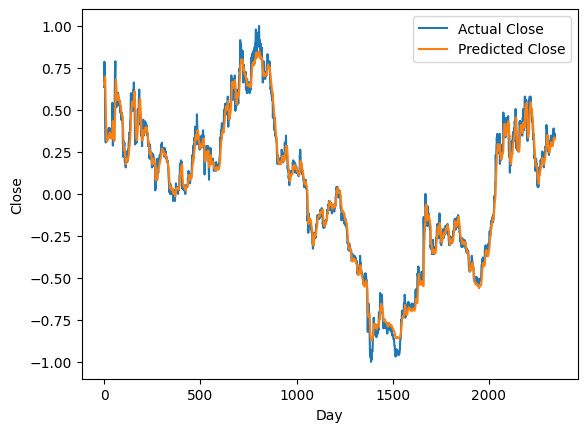

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [28]:
train_predictions = predicted.flatten()

#zeros matrix that looks like the shifted_df
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([2.11490073, 2.10537344, 2.13986082, ..., 1.80482422, 1.8066458 ,
       1.80566965])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([2.09450795, 2.2377231 , 2.21982095, ..., 1.82000004, 1.83000006,
       1.82000004])

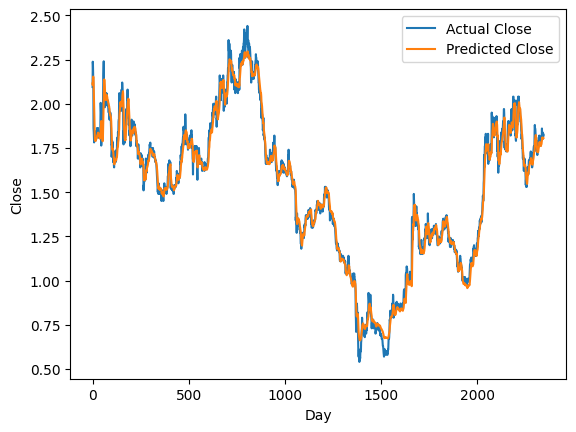

In [30]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

#now we get more accurate units


In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1.80408578, 1.8046892 , 1.80623046, 1.81272786, 1.81043819,
       1.80979695, 1.7776176 , 1.75591132, 1.73944335, 1.70916997,
       1.68749794, 1.6769423 , 1.66537716, 1.67998137, 1.68636178,
       1.68467693, 1.68914207, 1.69394708, 1.67876188, 1.67914953,
       1.67987253, 1.69894217, 1.71068514, 1.71218879, 1.71586204,
       1.72467732, 1.73199557, 1.71575351, 1.70115879, 1.68992556,
       1.68803246, 1.68971211, 1.68480038, 1.68109665, 1.67983104,
       1.68091069, 1.68223166, 1.6758333 , 1.66809509, 1.66665628,
       1.66127107, 1.66128563, 1.65699574, 1.65421819, 1.656356  ,
       1.65768804, 1.65798446, 1.64956381, 1.64522644, 1.63963583,
       1.62980809, 1.62626394, 1.62227038, 1.61856247, 1.61078308,
       1.60633936, 1.60977782, 1.61166207, 1.60281444, 1.60170177,
       1.60645044, 1.60623524, 1.60047382, 1.59984005, 1.60485071,
       1.60853511, 1.60122536, 1.60651009, 1.60879421, 1.611557  ,
       1.61321905, 1.62885511, 1.63646209, 1.64396505, 1.64854

In [32]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1.83000006, 1.83000006, 1.84000004, 1.82000004, 1.82000004,
       1.72000003, 1.70000004, 1.70000004, 1.64999998, 1.64999998,
       1.66999996, 1.66999996, 1.73000001, 1.73000001, 1.71000004,
       1.71000004, 1.71000004, 1.64999998, 1.66999996, 1.69000006,
       1.75999999, 1.76999998, 1.75000001, 1.75000001, 1.75000001,
       1.75000001, 1.67999995, 1.66999996, 1.66999996, 1.69000006,
       1.71000004, 1.70000004, 1.70000004, 1.69000006, 1.69000006,
       1.69000006, 1.66999996, 1.65999996, 1.66999996, 1.65999996,
       1.66999996, 1.65999996, 1.65999996, 1.66999996, 1.66999996,
       1.66999996, 1.63999998, 1.63999998, 1.62999999, 1.61000001,
       1.62000001, 1.62000001, 1.62000001, 1.60000003, 1.60000003,
       1.62000001, 1.62000001, 1.59000003, 1.60000003, 1.62000001,
       1.61000001, 1.59000003, 1.60000003, 1.62000001, 1.62000001,
       1.59000003, 1.62000001, 1.62000001, 1.62000001, 1.62000001,
       1.66999996, 1.66999996, 1.66999996, 1.66999996, 1.69000

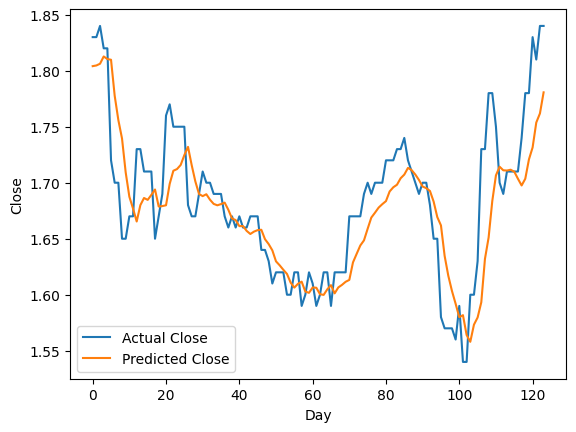

In [33]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [75]:
data_index.set_index("Date", inplace= True)

In [77]:
data_index

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-10,2.004999,2.130312,1.987098,2.112410,0.967453,407469748
2014-07-14,2.112410,2.166116,2.076607,2.112410,0.967453,217265144
2014-07-15,2.112410,2.148214,2.058705,2.076607,0.951056,148527866
2014-07-16,2.076607,2.130312,2.058705,2.094508,0.959254,167957437
2014-07-17,2.112410,2.112410,2.076607,2.076607,0.951056,49962949
...,...,...,...,...,...,...
2024-09-09,1.780000,1.780000,1.780000,1.780000,1.780000,0
2024-09-10,1.860000,1.860000,1.830000,1.830000,1.830000,141308600
2024-09-11,1.840000,1.840000,1.790000,1.810000,1.810000,158742300


In [79]:
df = data_index.loc["2014-07-10": "2024-09-15", "Close"].to_frame()

In [81]:
df

,Close
Date,
2014-07-10,2.112410
2014-07-14,2.112410
2014-07-15,2.076607
2014-07-16,2.094508
2014-07-17,2.076607
...,...
2024-09-09,1.780000
2024-09-10,1.830000
2024-09-11,1.810000


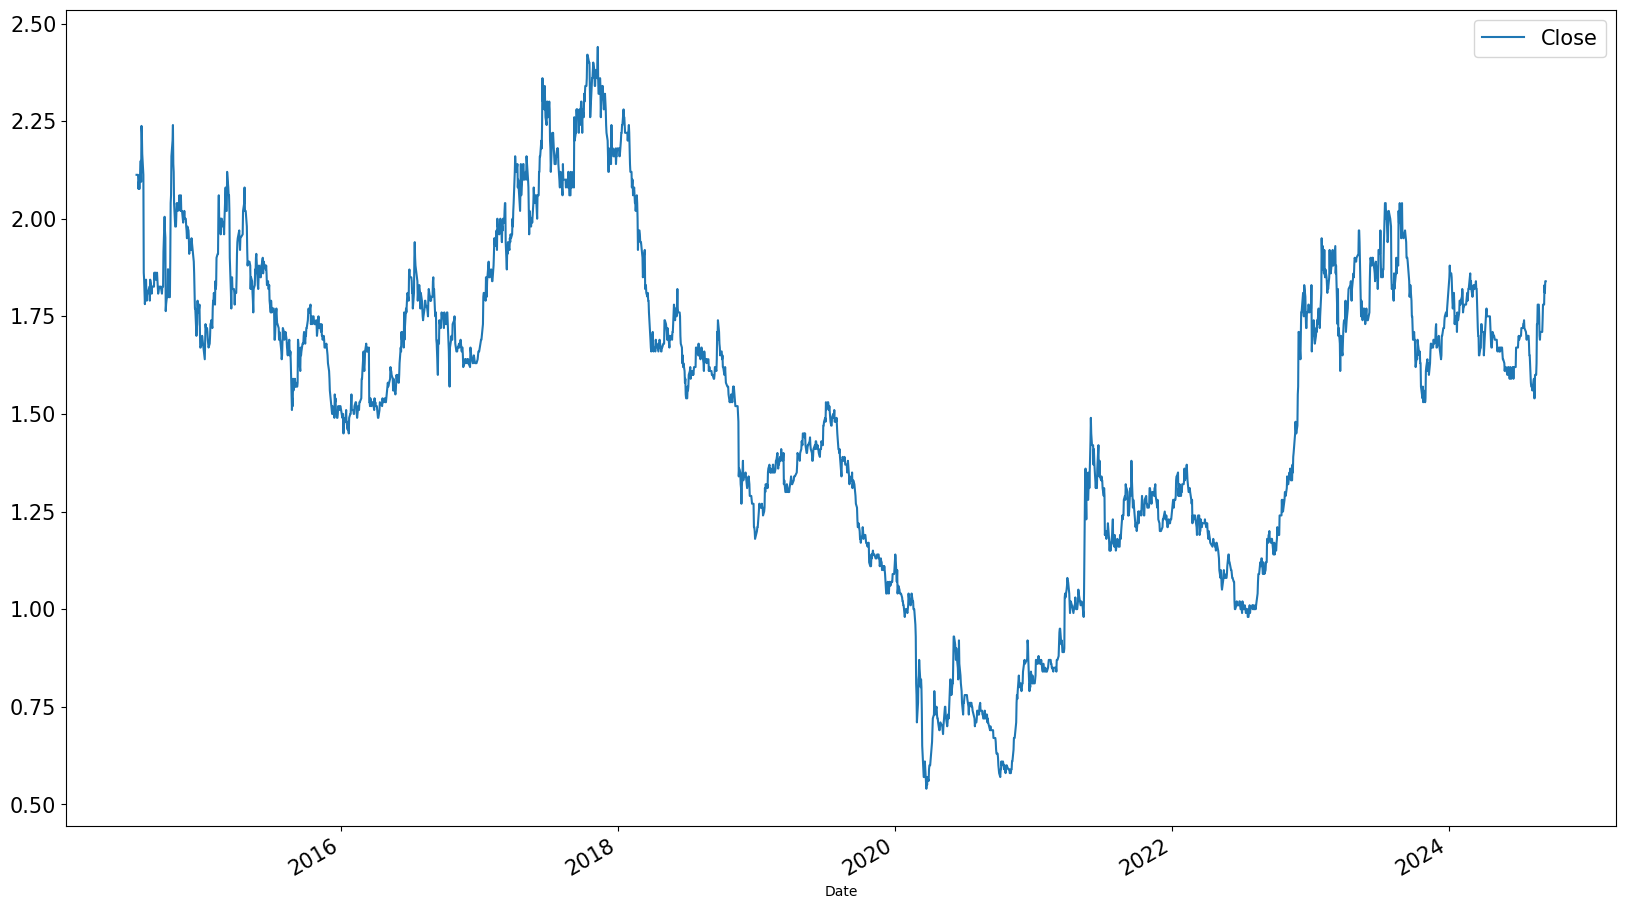

In [83]:
df.plot(figsize = (20, 12), fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [85]:
df["Return"] = df.pct_change() #get the returns

In [87]:
df.head(20)

,Close,Return
Date,,
2014-07-10,2.112410,NaN
2014-07-14,2.112410,0.000000
2014-07-15,2.076607,-0.016949
2014-07-16,2.094508,0.008620
2014-07-17,2.076607,-0.008547
2014-07-18,2.076607,0.000000
2014-07-21,2.148214,0.034483
2014-07-22,2.094508,-0.025000
2014-07-23,2.237723,0.068377


In [89]:
df.dropna(inplace = True)

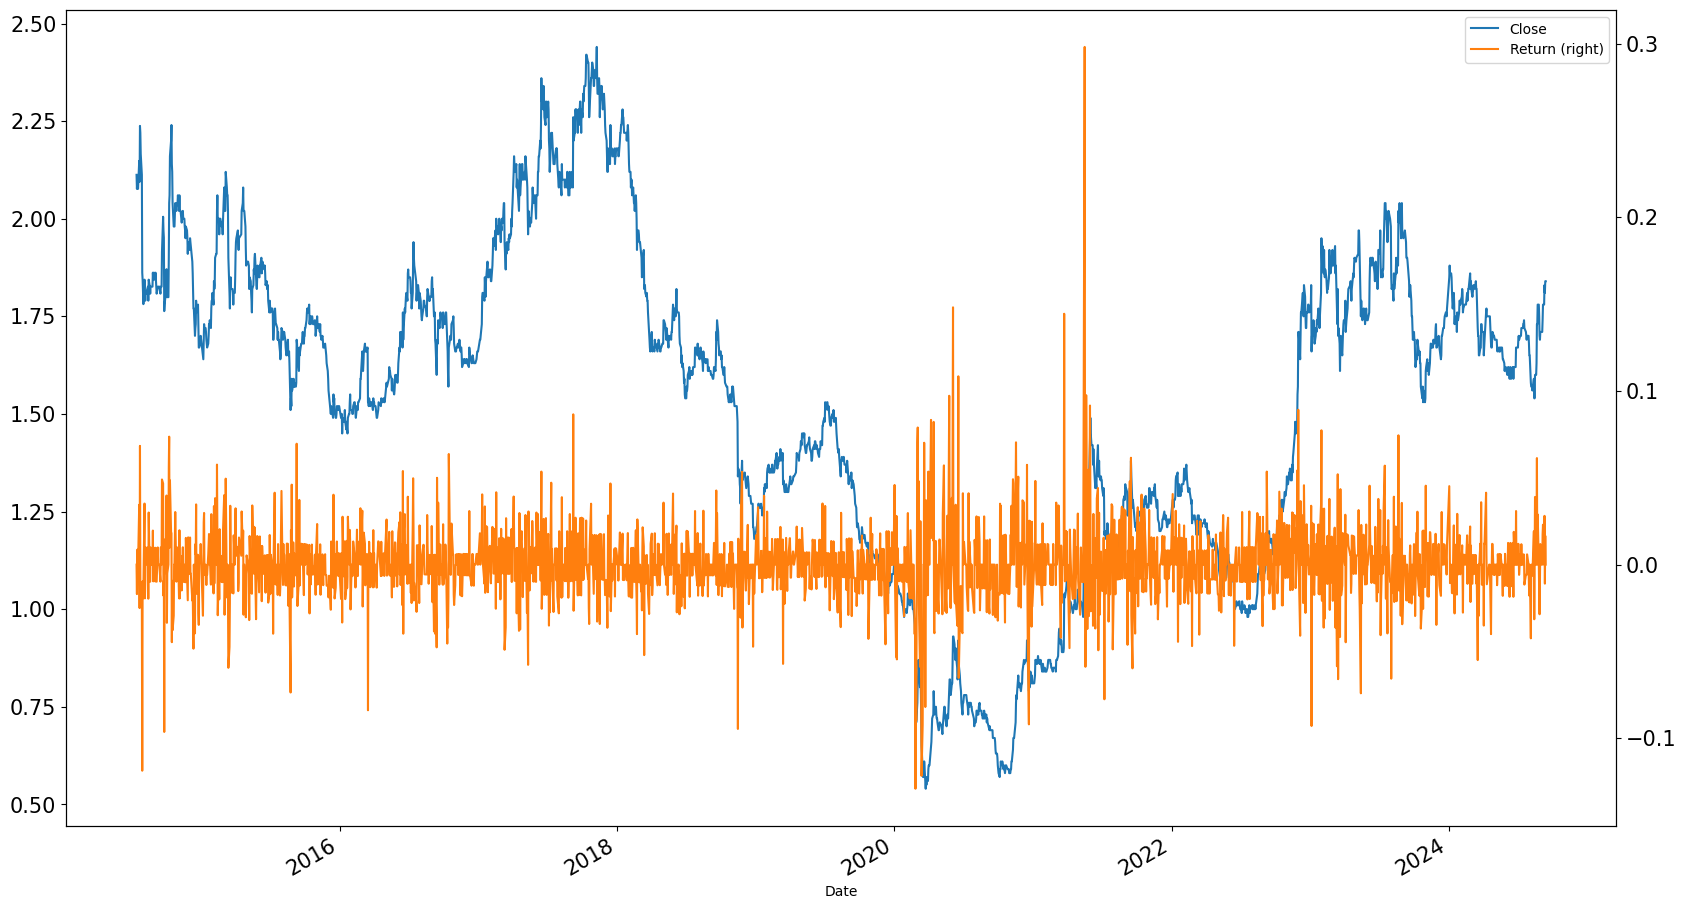

In [91]:
df.plot(figsize = (20, 12), secondary_y = "Return", mark_right = True, fontsize = 15)
plt.show()

In [93]:
df.rename(columns = {"Close":"SANSIRI_Close", "Return":"SANSIRI_Return"}, inplace = True)

In [95]:
df

,SANSIRI_Close,SANSIRI_Return
Date,,
2014-07-14,2.112410,0.000000
2014-07-15,2.076607,-0.016949
2014-07-16,2.094508,0.008620
2014-07-17,2.076607,-0.008547
2014-07-18,2.076607,0.000000
...,...,...
2024-09-09,1.780000,0.000000
2024-09-10,1.830000,0.028090
2024-09-11,1.810000,-0.010929


In [97]:
df["Position"] = np.sign(df["SANSIRI_Return"])
df["Strategy_Ret"] = df["Position"].shift() * df["SANSIRI_Return"]

#here we create position used for backtesting both long and short term

In [99]:
df

,SANSIRI_Close,SANSIRI_Return,Position,Strategy_Ret
Date,,,,
2014-07-14,2.112410,0.000000,0.0,NaN
2014-07-15,2.076607,-0.016949,-1.0,-0.000000
2014-07-16,2.094508,0.008620,1.0,-0.008620
2014-07-17,2.076607,-0.008547,-1.0,-0.008547
2014-07-18,2.076607,0.000000,0.0,-0.000000
...,...,...,...,...
2024-09-09,1.780000,0.000000,0.0,0.000000
2024-09-10,1.830000,0.028090,1.0,0.000000
2024-09-11,1.810000,-0.010929,-1.0,-0.010929


In [101]:
df.Strategy_Ret.add(1, fill_value = 0).cumprod()

Date
2014-07-14    1.000000
2014-07-15    1.000000
2014-07-16    0.991380
2014-07-17    0.982907
2014-07-18    0.982907
                ...   
2024-09-09    0.444854
2024-09-10    0.444854
2024-09-11    0.439992
2024-09-12    0.432699
2024-09-13    0.432699
Name: Strategy_Ret, Length: 2475, dtype: float64

In [103]:
df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0]

In [105]:
df

,SANSIRI_Close,SANSIRI_Return,Position,Strategy_Ret,Strategy
Date,,,,,
2014-07-14,2.112410,0.000000,0.0,NaN,2.112410
2014-07-15,2.076607,-0.016949,-1.0,-0.000000,2.112410
2014-07-16,2.094508,0.008620,1.0,-0.008620,2.094200
2014-07-17,2.076607,-0.008547,-1.0,-0.008547,2.076302
2014-07-18,2.076607,0.000000,0.0,-0.000000,2.076302
...,...,...,...,...,...
2024-09-09,1.780000,0.000000,0.0,0.000000,0.939713
2024-09-10,1.830000,0.028090,1.0,0.000000,0.939713
2024-09-11,1.810000,-0.010929,-1.0,-0.010929,0.929443


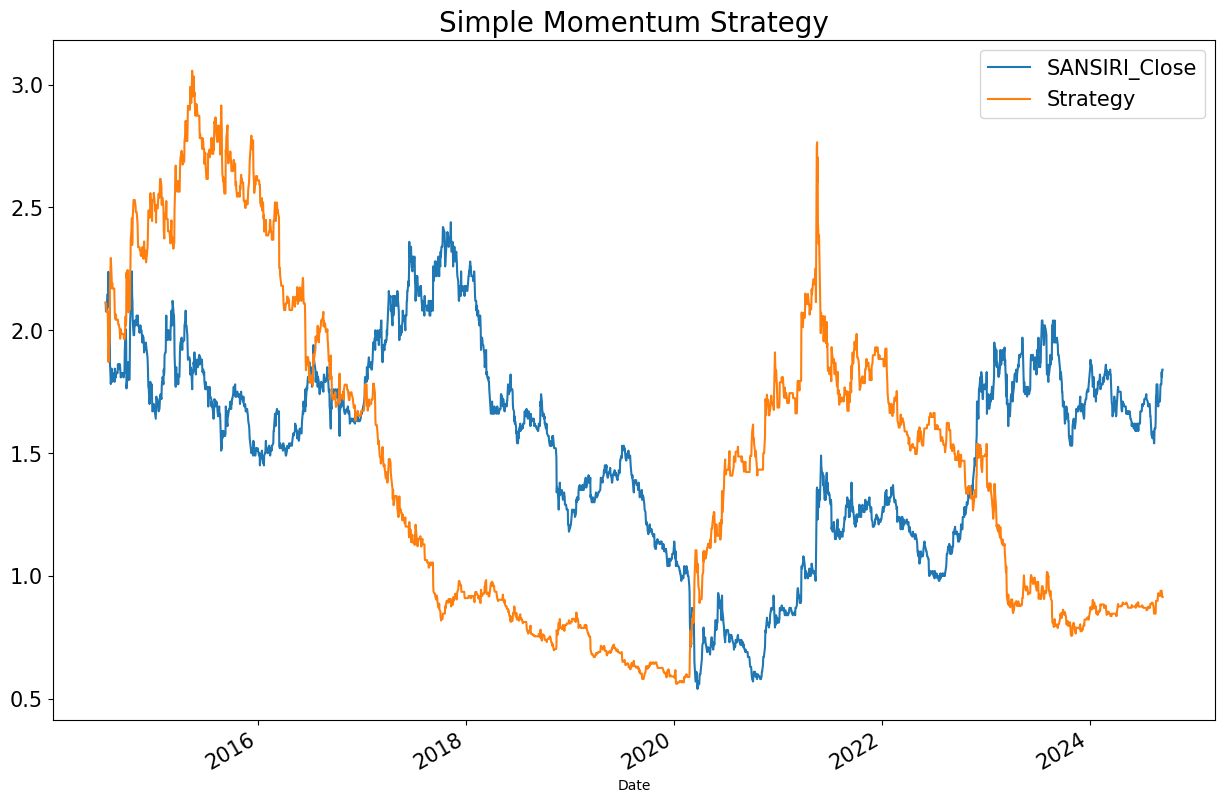

In [111]:
df[["SANSIRI_Close", "Strategy"]].plot(figsize = (15, 10), fontsize = 15)
plt.title("Simple Momentum Strategy", fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

In [113]:
def summary_ann(returns):
    summary = returns.agg(["mean", "std"]).T
    summary["Return"] = summary["mean"] * 252
    summary["Risk"] = summary["std"] * np.sqrt(252)
    summary.drop(columns = ["mean", "std"], inplace = True)
    return summary

In [115]:
summary_ann(df[["SANSIRI_Return", "Strategy_Ret"]])

,Return,Risk
SANSIRI_Return,0.042969,0.340091
Strategy_Ret,-0.037939,0.311461


In [117]:
# Buy and Hold (Basic Strategy): Initially Investing into Sansiri and do nothing (Position: +1 on all days)
#Retun annually 4%, our strategy thus underperforms basic buy & hold  in long term. 4% vs -3% per year annualized

# Simple Moving Average

In [121]:
data_index

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-10,2.004999,2.130312,1.987098,2.112410,0.967453,407469748
2014-07-14,2.112410,2.166116,2.076607,2.112410,0.967453,217265144
2014-07-15,2.112410,2.148214,2.058705,2.076607,0.951056,148527866
2014-07-16,2.076607,2.130312,2.058705,2.094508,0.959254,167957437
2014-07-17,2.112410,2.112410,2.076607,2.076607,0.951056,49962949
...,...,...,...,...,...,...
2024-09-09,1.780000,1.780000,1.780000,1.780000,1.780000,0
2024-09-10,1.860000,1.860000,1.830000,1.830000,1.830000,141308600
2024-09-11,1.840000,1.840000,1.790000,1.810000,1.810000,158742300


In [123]:
df2 =  data_index.loc["2014":, "Close"].to_frame()
df2["SANSIRI_Return"] = df2.Close.pct_change()
df2.columns = ["SANSIRI_Close", "SANSIRI_Return"]
df2.dropna(inplace = True)

In [125]:
df2

,SANSIRI_Close,SANSIRI_Return
Date,,
2014-07-14,2.112410,0.000000
2014-07-15,2.076607,-0.016949
2014-07-16,2.094508,0.008620
2014-07-17,2.076607,-0.008547
2014-07-18,2.076607,0.000000
...,...,...
2024-09-09,1.780000,0.000000
2024-09-10,1.830000,0.028090
2024-09-11,1.810000,-0.010929


In [127]:
df2.SANSIRI_Close.rolling(window = 50).mean()
#we get missing values here because we do not have data for the immediately preceding 50 days.
#this is the average price for the immediately preceding fifty trading days.

Date
2014-07-14       NaN
2014-07-15       NaN
2014-07-16       NaN
2014-07-17       NaN
2014-07-18       NaN
               ...  
2024-09-09    1.6814
2024-09-10    1.6846
2024-09-11    1.6874
2024-09-12    1.6908
2024-09-13    1.6942
Name: SANSIRI_Close, Length: 2475, dtype: float64

In [129]:
df2 ["SMA50"] = df2.SANSIRI_Close.rolling(window = 50).mean()

In [131]:
df2

,SANSIRI_Close,SANSIRI_Return,SMA50
Date,,,
2014-07-14,2.112410,0.000000,NaN
2014-07-15,2.076607,-0.016949,NaN
2014-07-16,2.094508,0.008620,NaN
2014-07-17,2.076607,-0.008547,NaN
2014-07-18,2.076607,0.000000,NaN
...,...,...,...
2024-09-09,1.780000,0.000000,1.6814
2024-09-10,1.830000,0.028090,1.6846
2024-09-11,1.810000,-0.010929,1.6874


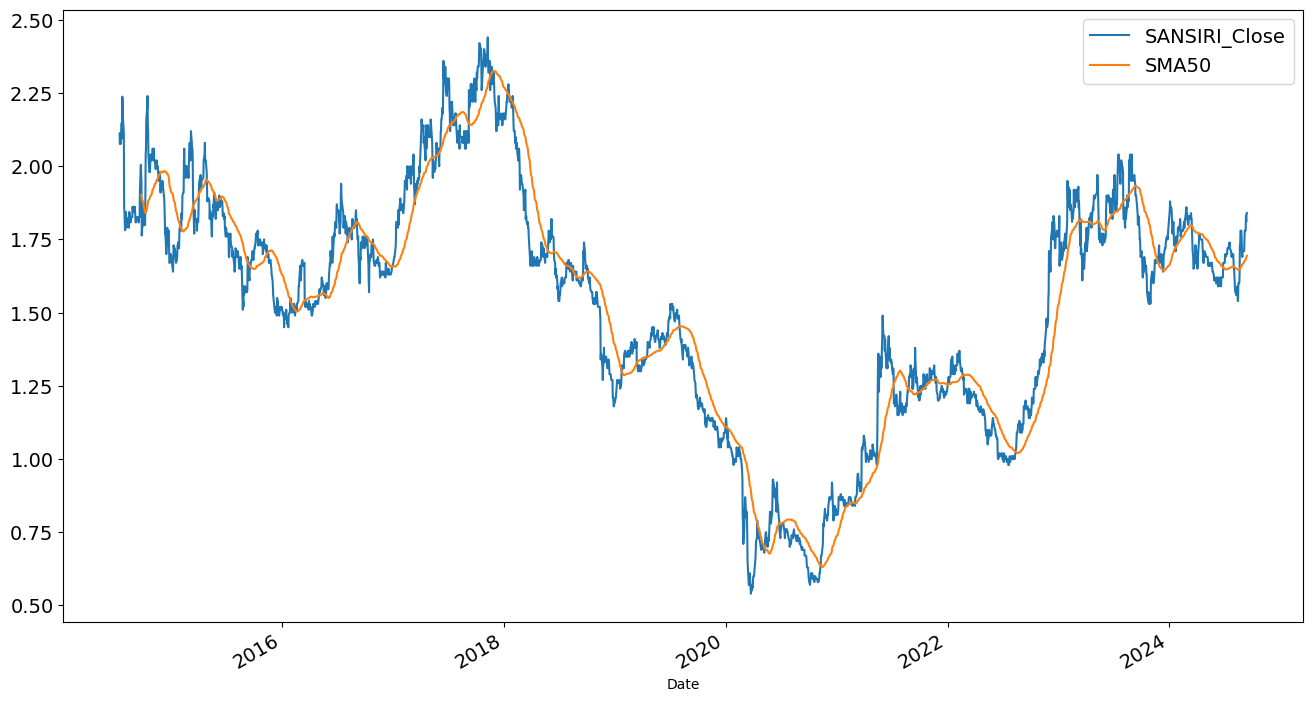

In [133]:
df2[["SANSIRI_Close", "SMA50"]].plot(figsize = (16,9), fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [135]:
df2 ["SMA200"] = df2.SANSIRI_Close.rolling(window = 200).mean()

In [137]:
df2

,SANSIRI_Close,SANSIRI_Return,SMA50,SMA200
Date,,,,
2014-07-14,2.112410,0.000000,NaN,NaN
2014-07-15,2.076607,-0.016949,NaN,NaN
2014-07-16,2.094508,0.008620,NaN,NaN
2014-07-17,2.076607,-0.008547,NaN,NaN
2014-07-18,2.076607,0.000000,NaN,NaN
...,...,...,...,...
2024-09-09,1.780000,0.000000,1.6814,1.70865
2024-09-10,1.830000,0.028090,1.6846,1.70980
2024-09-11,1.810000,-0.010929,1.6874,1.71070


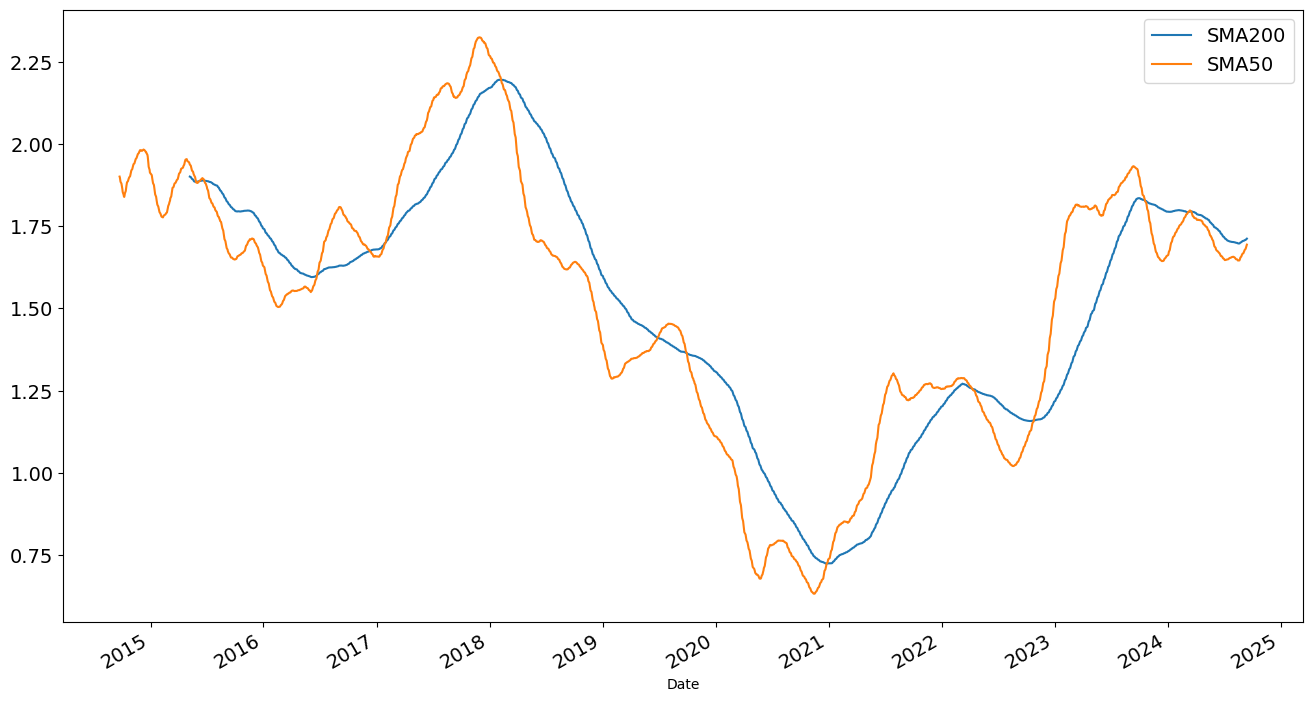

In [139]:
df2[["SMA200", "SMA50"]].plot(figsize = (16,9), fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [141]:
df2.dropna(inplace = True)

In [143]:
df2["position"] = np.sign(df2.SMA50.sub(df2.SMA200))
#short term vs medium term position

In [145]:
df2 #returns position for integer 

,SANSIRI_Close,SANSIRI_Return,SMA50,SMA200,position
Date,,,,,
2015-05-08,1.85,0.016484,1.9380,1.901338,1.0
2015-05-11,1.84,-0.005405,1.9348,1.899976,1.0
2015-05-12,1.81,-0.016304,1.9310,1.898643,1.0
2015-05-13,1.79,-0.011050,1.9272,1.897120,1.0
2015-05-14,1.76,-0.016760,1.9226,1.895537,1.0
...,...,...,...,...,...
2024-09-09,1.78,0.000000,1.6814,1.708650,-1.0
2024-09-10,1.83,0.028090,1.6846,1.709800,-1.0
2024-09-11,1.81,-0.010929,1.6874,1.710700,-1.0


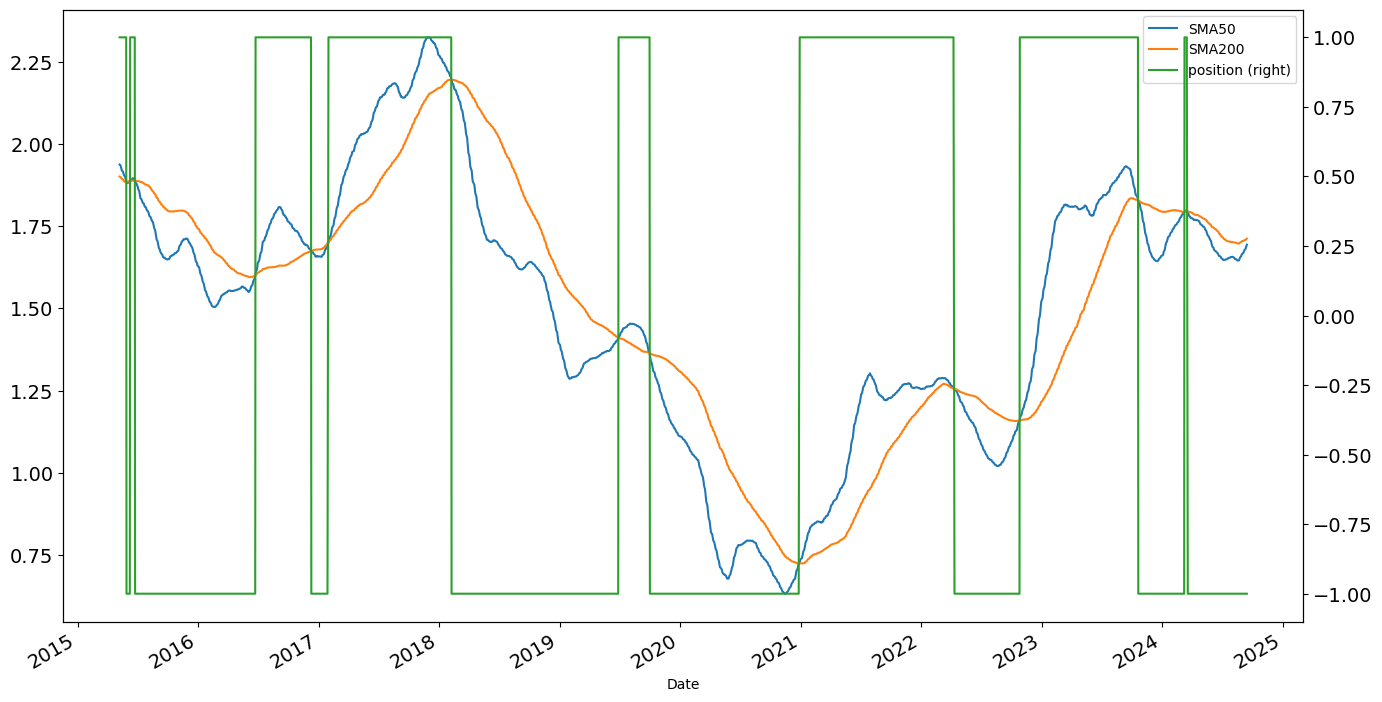

In [147]:
df2 [["SMA50","SMA200", "position"]].plot(figsize = (16,9), fontsize = 14, secondary_y = "position") 
plt.show()
#plot the estimates with the position
#the curved cross changes the position

In [149]:
df2["Strategy_Return"] = df2["position"].shift() * df2["SANSIRI_Return"]

In [151]:
df2["Strategy"] = df2.Strategy_Return.add(1, fill_value = 0).cumprod() * df2.iloc[0,0]

In [153]:
df2

,SANSIRI_Close,SANSIRI_Return,SMA50,SMA200,position,Strategy_Return,Strategy
Date,,,,,,,
2015-05-08,1.85,0.016484,1.9380,1.901338,1.0,NaN,1.850000
2015-05-11,1.84,-0.005405,1.9348,1.899976,1.0,-0.005405,1.840000
2015-05-12,1.81,-0.016304,1.9310,1.898643,1.0,-0.016304,1.810000
2015-05-13,1.79,-0.011050,1.9272,1.897120,1.0,-0.011050,1.790000
2015-05-14,1.76,-0.016760,1.9226,1.895537,1.0,-0.016760,1.760000
...,...,...,...,...,...,...,...
2024-09-09,1.78,0.000000,1.6814,1.708650,-1.0,-0.000000,2.133946
2024-09-10,1.83,0.028090,1.6846,1.709800,-1.0,-0.028090,2.074003
2024-09-11,1.81,-0.010929,1.6874,1.710700,-1.0,0.010929,2.096670


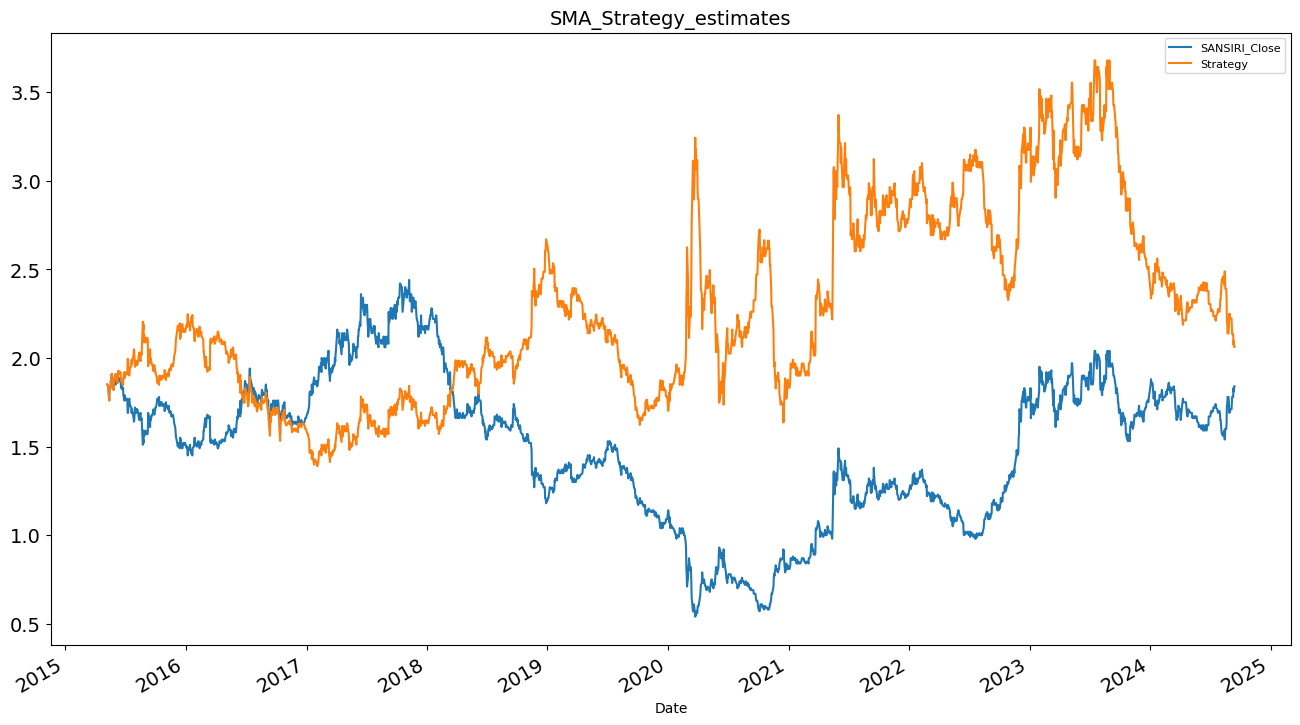

In [155]:
df2[["SANSIRI_Close","Strategy"]].plot(figsize = (16,9), fontsize = 14)
plt.legend(fontsize = 8)
plt.title("SMA_Strategy_estimates", fontsize = 14)
plt.show()

#we see that our SMA strategy overperform in the longer periods of time as price tends to persist over longer time than Simple momentum strategy that takes daily estimates

In [163]:
summary_ann(df2[["SANSIRI_Return", "Strategy_Return"]])

,Return,Risk
SANSIRI_Return,0.057106,0.337151
Strategy_Return,0.067956,0.337172
